In [9]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")
    os.environ["LANGSMITH_TRACING"] = "true"
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Enter API key for LangSmith: ")
 

from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
llm = init_chat_model("gpt-4o-mini", model_provider="openai")

Enter API key for OpenAI:  ········
Enter API key for LangSmith:  ········


In [10]:
from langchain_milvus import Milvus
from pymilvus import CollectionSchema, FieldSchema, DataType 

VECTOR_STORE_URI = "./milvus_example.db"


# Define the schema fields
# fields = [
#     FieldSchema(
#         name="embedding",
#         dtype=DataType.FLOAT_VECTOR,
#         is_primary=True,
#         dim=1536  # or whatever dimension you are using
#     ),
#     FieldSchema(
#         name="section",
#         dtype=DataType.VARCHAR,
#         max_length=256,  # must set a max length for VARCHAR
#         is_primary=False
#     ),
# ]

# schema = CollectionSchema(
#     fields=fields,
#     # Let Milvus automatically generate IDs if needed
#     auto_id=True,
#     # Enable dynamic fields if you'd like to store other metadata fields
#     # as "dynamic" columns. This is optional.
#     enable_dynamic_field=True
# )

vector_store = Milvus(
    embedding_function=embeddings,
    connection_args={"uri": VECTOR_STORE_URI},
    index_params={"index_type": "FLAT", "metric_type": "COSINE"},
    collection_name="website_content",
    auto_id=True,
    #collection_schema=schema,
    #create_collection=True,
    consistency_level="Strong",
    enable_dynamic_field=True,
    drop_old=True,  # set to True if seeking to drop the collection with that name if it exists
)

In [11]:
import pandas as pd

df = pd.read_csv("../storage/output/index.csv")
df.fillna("", inplace=True)
web_paths = df["url"].values.tolist()
print(web_paths)

['https://mitrix.biz', 'https://mitrix.biz/portfolio/online-learning-automation-platform/', 'https://mitrix.biz/portfolio/online-ticketing-platform/', 'https://mitrix.biz/portfolio/lead-generation-and-social-selling-platform/', 'https://mitrix.biz/portfolio/healthcare-medical-record-management/', 'https://mitrix.biz/contacts/', 'https://mitrix.biz/services/startup-development/', 'https://mitrix.biz/services/team-augmentation/', 'https://mitrix.biz/services/dedicated-team/', 'https://mitrix.biz/portfolio/', 'https://mitrix.biz/services/custom-web-development/', 'https://mitrix.biz/services/mobile-appication-development/', 'https://mitrix.biz/services/digital-transformation/', 'https://mitrix.biz/services/business-intelligence/', 'https://mitrix.biz/services/cloud-native-development/', 'https://mitrix.biz/services/consulting/', 'https://mitrix.biz/services/']


In [12]:
sections = df['section'].unique().tolist()
print(sections)

['homepage', 'portfolio', 'contacts', 'services']


In [13]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

loader = WebBaseLoader(
    web_paths=web_paths,
    #bs_kwargs=dict(features="html.parser")
    )

docs = loader.load()

cleaned_docs = []
for doc in docs:
    soup = bs4.BeautifulSoup(doc.page_content, "html.parser")
    
    # Remove unwanted tags
    for tag in soup(["script", "style", "noscript"]):
        tag.extract()
    
    # Extract text
    text = soup.get_text(separator=" ", strip=True)
    text = " ".join(text.split())
    
    # Create a new Document with the cleaned text (preserving metadata)
    cleaned_doc = Document(
        page_content=text,
        metadata=doc.metadata
    )
    cleaned_docs.append(cleaned_doc)

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200, add_start_index=True)
all_splits = text_splitter.split_documents(cleaned_docs)
print("Total chunked documents:", len(all_splits))

USER_AGENT environment variable not set, consider setting it to identify your requests.


Total chunked documents: 162


In [14]:
# TODO: implement section splitting based on source from df
for document in all_splits:
    # The `metadata["source"]` in WebBaseLoader often is the URL
    doc_source = document.metadata.get("source", "")
    
    # Filter by URL in the DataFrame
    filtered_df = df[df["url"] == doc_source]
    if not filtered_df.empty:
        section_value = filtered_df.iloc[0]["section"]
    else:
        section_value = ""
    
    document.metadata["section"] = section_value

split = all_splits[106]
print(split)

page_content='your workforce and customers to interact with your business anytime, anywhere. contact usPath to Digital GrowthOur digital transforma-tion processAt Mitrix, we guide businesses through every step of their digital transformation journey. Our tailored approach ensures seamless integration and lasting impact Performing an AuditAssess current systems, identify inefficiencies, and uncover digital transformation opportunities. Prioritizing TransformationsFocus on high-impact changes that align with business needs and maximize efficiency. Aligning Strategy with GoalsEnsure digital initiatives support overall business objectives for sustainable growth. Launching a Proof-of-ConceptTest solutions on a small scale to validate effectiveness before full implementation. Building Long-Term Partnershipse provide ongoing support and innovation to drive your digital transformation forward.1 / Audit2 / Prioritizing3 / Strategy4 / POC launch5 / PartnershipsStay Ahead in BusinessWhy invest in

In [15]:
from uuid import uuid4
# Index chunks
#uuids = [str(uuid4()) for _ in range(len(all_splits))]
# https://python.langchain.com/docs/tutorials/retrievers/

document_ids = vector_store.add_documents(documents=all_splits)
print(document_ids[:3])

[456485308489531392, 456485308489531393, 456485308489531394]


In [16]:
# Define prompt for question-answering
base_prompt = hub.pull("mitrixgpt-base")

In [17]:
from typing import Literal
from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["homepage", "portfolio", "contacts", "services"],
        ...,
        "Section to query.",
    ]

class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    #print(query["section"])
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"], k = 3
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = base_prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


In [18]:
# Compile application and test
graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

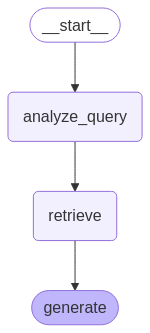

In [19]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
response = graph.invoke({"question": "Why should I choose Mitrix?"})
print(f'Context: {response["context"]}\n\n')
print(f'Answer: {response["answer"]}')

Context: [Document(metadata={'source': 'https://mitrix.biz/services/', 'title': 'Services - MITRIX Technology company', 'description': 'Our team offers various software development, dedicated teams and staff augmentation solutions for your needs.', 'language': 'en-US', 'start_index': 4007, 'section': 'services', 'pk': 456485308489531550}, page_content="looking to automate their own learning processes.choice based on factsWhy choose MitrixChoosing Mitrix Technology means partnering with a team that combines technical expertise with a strong commitment to your business goals. We adhere to a comprehensive approach that involves assessing the product idea to determine the most effective path to successful delivery. 60+ experienced developers Project managers and team leads available Project managers and team leads available The team can be scaled up or down as needed Dedicated teams engagement mode Cybersecurity and quality management policies in placeWhat our clients say Mitrix's team use

In [21]:
# Specisic section scope Q&A 
for step in graph.stream(
    {"question": "What's your team expertize, skills and tech stack?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'team expertise skills and tech stack', 'section': 'homepage'}}}

----------------

{'retrieve': {'context': [Document(metadata={'source': 'https://mitrix.biz/services/team-augmentation/', 'title': 'Team Augmentation - MITRIX Technology', 'language': 'en-US', 'start_index': 2398, 'section': 'services', 'pk': 456485308489531444}, page_content='career aspirations. Web developers Mobile developers DevOps engineers Designers Software testers wide tech stack listWhy choose Mitrix as a team augmentation companyMitrix works with highly-skilled candidates, so you’ll never need to worry about their expertise. You’ll be able to choose from 2-3 top candidates who best fit your needs. The specialist you hire will be ready to start working for your company in short notice. Job openings can be filled quickly, and you can trust that your new hire will efficiently complete all required tasks. Moreover, you’ll have access to leading professionals who may not be ava

In [22]:
# Specisic section scope Q&A 
for step in graph.stream(
    {"question": "What's the capital of Somalia?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'What is the capital city of Somalia?', 'section': 'homepage'}}}

----------------

{'retrieve': {'context': [Document(metadata={'source': 'https://mitrix.biz/portfolio/healthcare-medical-record-management/', 'title': 'Healthcare medical record management - MITRIX Technology', 'language': 'en-US', 'start_index': 5618, 'section': 'portfolio', 'pk': 456485308489531426}, page_content="in floating capital.Technologies: Winform APP Entity Framework C# Angular Azure Functions Azure Blob Storages CosmosDB Azure App Services Azure Managed Instance Ms sql Azure Service Bus Have an idea? Let's talk NameCompany nameE-mailMessageBy sending this request, you agree to oursend request ul. Bagno 2ENTRANCE E/1 FLOOR, 00-112, Warsaw, Poland +48 571 940 423 (PL) +1 (773) 790 4050 (USA) info@mitrix.io servicesWeb developmentCloud developmentDigital transformationMobile developmentBusiness intelligenceConsultingPortfolioDedicated teamTeam AugmentationStartup Developmen

# Chat Logic

In [23]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [24]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode

from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=3)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (f"{base_prompt}"
                             "\n\n"
                             "{docs_content}")
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [25]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)


graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

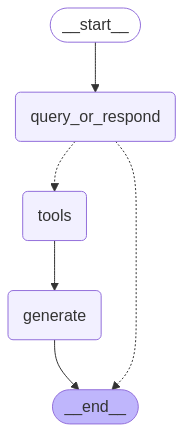

In [26]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))



In [27]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I assist you today?


In [28]:
input_message = "What is the capital of China?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is the capital of China?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_6qym6UbUZCb9WMZcsRbII41W)
 Call ID: call_6qym6UbUZCb9WMZcsRbII41W
  Args:
    query: capital of China
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://mitrix.biz/portfolio/healthcare-medical-record-management/', 'title': 'Healthcare medical record management - MITRIX Technology', 'language': 'en-US', 'start_index': 5618, 'section': 'portfolio', 'pk': 456485308489531426}
Content: in floating capital.Technologies: Winform APP Entity Framework C# Angular Azure Functions Azure Blob Storages CosmosDB Azure App Services Azure Managed Instance Ms sql Azure Service Bus Have an idea? Let's talk NameCompany nameE-mailMessageBy sending this request, you agree to oursend request ul. Bagno 2ENTRANCE E/1 FL

In [29]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [30]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_FqGvEb8FgqVttj7ClRsSdOqE)
 Call ID: call_FqGvEb8FgqVttj7ClRsSdOqE
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://mitrix.biz', 'title': 'Individual Software Development solutions - MITRIX Technology company', 'description': 'Our team offers various software development, dedicated teams and staff augmentation solutions for your needs.', 'language': 'en-US', 'start_index': 4808, 'section': 'homepage', 'pk': 456485308489531398}
Content: your vision into a user-friendly experience. DeliveryAs enthusiasts of Continuous Delivery, we act on instant feedback from our clients, keeping them informed every step of the way. DevelopmentWe turn your project idea into a c

In [31]:
input_message = "Can you look up some common ways of doing it?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up some common ways of doing it?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_msRp4DATMaX45V80mrjlGCs7)
 Call ID: call_msRp4DATMaX45V80mrjlGCs7
  Args:
    query: common methods of task decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://mitrix.biz/services/digital-transformation/', 'title': 'Digital transformation - MITRIX Technology', 'language': 'en-US', 'start_index': 813, 'section': 'services', 'pk': 456485308489531497}
Content: automationStreamlining workflows and automating repetitive tasks to improve efficiency and reduce operational costs.Cloud migrationHelping businesses move their existing applications and infrastructure to cloud platforms, optimizing for scalability and cost-efficiency.Legacy system modernizationUpgrading outdated 

In [32]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)
agent_executor.get_graph().to_json()

{'nodes': [{'id': '__start__', 'type': 'schema', 'data': '__start__'},
  {'id': 'agent',
   'type': 'runnable',
   'data': {'id': ['langgraph', 'utils', 'runnable', 'RunnableCallable'],
    'name': 'agent'}},
  {'id': 'tools',
   'type': 'runnable',
   'data': {'id': ['langgraph', 'prebuilt', 'tool_node', 'ToolNode'],
    'name': 'tools'}},
  {'id': '__end__', 'type': 'schema', 'data': '__end__'}],
 'edges': [{'source': '__start__', 'target': 'agent'},
  {'source': 'tools', 'target': 'agent'},
  {'source': 'agent', 'target': 'tools', 'conditional': True},
  {'source': 'agent', 'target': '__end__', 'conditional': True}]}

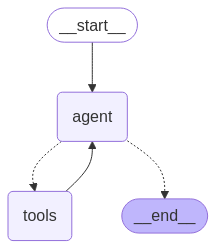

In [33]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [34]:

input_message = (
    "What is the Mitrix team expertize?\n\n"
    "Once you get the answer, look up for bakcend technologies used by the team."
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the Mitrix team expertize?

Once you get the answer, look up for bakcend technologies used by the team.
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_71arXFP1SDESn8tNHjWKiBqJ)
 Call ID: call_71arXFP1SDESn8tNHjWKiBqJ
  Args:
    query: Mitrix team expertise
  retrieve (call_O74WaXImexSv4jxvwAZkQVaN)
 Call ID: call_O74WaXImexSv4jxvwAZkQVaN
  Args:
    query: backend technologies used by Mitrix team
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://mitrix.biz/portfolio/', 'title': 'Portfolio - MITRIX Technology', 'language': 'en-US', 'start_index': 800, 'section': 'portfolio', 'pk': 456485308489531467}
Content: The solution enabling healthcare providers to track patient histories, monitor progress, and make informed decisions. The Mitrix team developed a solution 